# Homework 2

### Deadline: Tuesday 20 May 2025 (by 19h00)

### Credits: 20 points


## Instructions:

- The homework is **individual**. Please include your name in the notebook.

- **Please send your compressed tar file with the following tree scheme:**

```
homework2.tar
    
    pdediffusion
    ├── metalconduction.ipynb
    ├── metalconduction.py     
    └── outputfolder
```

## Name:

## 1. Thermodynamics and Heat Conduction (12 points)

Please include your solutions to this problem within a single python notebook file: **metalconduction.ipynb**

Use appropriate numerical algorithms to study how the temperature profile in a heated metal wire evolves in time, under different initial and boundary conditions. For this, you need to numerically solve the 1D heat equation:

$$\frac{\partial T}{\partial t}=\alpha\frac{\partial^2 T}{\partial x^2}$$

where $T=T(x, t)$ describes the temperature of the metal, $x$ is position, $t$ is time, and $\alpha$ is the thermal diffusivity of the metal. We will consider the following metals:

| Metal      | $\alpha$ ($\frac{mm^2}{s}$) |
|------------|--------------------------|
| Copper     | 111                      |
| Iron       | 23                       |
| Aluminum   | 97                       |
| Brass      | 34                       |
| Steel      | 18                       |
| Zinc       | 63                       |
| Lead       | 22                       |
| Titanium   | 9.8                      |

Assume that the metal wire has a length of $20\,\rm cm$, and choose the wire midpoint as the origin for the domain.

### Code design:

Organise your code using **python classes** and carry out the following tasks:

**(a)** Place the metals and diffusivities in a python dictionary.

**(bx2)** Create a simulation initialisation routine where e.g. the mesh, the initial conditions, and the boundary conditions are all set up.

Consider two types of **initial conditions**:

- **Smooth**, which sets the initial temperature profile in degrees Celsius to be:

$$T(x, 0)= 175 - 50\cos\left(\frac{\pi x}{5}\right) - x^2$$

where $x$ is in units of $\rm cm$. 

- **Noisy**, which adds some noise $f(x)$ with amplitude $\beta$ to the initial condition:

$$T(x, 0)= 175 - 50\cos\left(\frac{\pi x}{5}\right) - x^2 + \beta\,f(x)\,g(x)$$

Note that you need to find an appropriate apodisation function $g(x)$ so that the initial boundary conditions remain fixed at $25\,\rm C$. Similarly, a default amplitude for the noise function can be set to be less than a hundredth of the peak temperature value. 

Also, consider two types of **boundary conditions**:

- **Fixed**, which keep the temperatures at the edges of the metal wire fixed at a temperature of $25\,\rm C$. 
    
- **Varying**, which assume that the boundaries cannot be kept constant (because of e.g. a faulty cooling system). Instead they also evolve in time according to the following functions:

    $T(+10\,{\rm cm}, t) = 25 + 0.12\,t$

    $T(-10\,{\rm cm}, t) = 25 + 0.27\,t$

**(cx3)** Construct a Crank-Nicolson algorithm to simulate **the evolution of an initial temperature profile** and find the **time in seconds at which thermal equilibrium is reached** in an input metal wire (from the dictionary). **Hint:** You need to define some criteria to determine thermal equilibrium.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time
import os

class MetalConduction:
    """
    Class for simulating heat conduction in metal wires using the Crank-Nicolson method
    """
    
    def __init__(self, metal_name='Copper', length=20.0, dx=0.1, dt=0.01, 
                 ic_type='smooth', bc_type='fixed', noise_amplitude=0.0):
        """
        Initialize the simulation parameters
        
        Parameters:
        -----------
        metal_name : str
            Name of the metal for the simulation
        length : float
            Length of the metal wire in cm
        dx : float
            Spatial step size in cm
        dt : float
            Time step size in seconds
        ic_type : str
            Type of initial condition ('smooth' or 'noisy')
        bc_type : str
            Type of boundary condition ('fixed' or 'varying')
        noise_amplitude : float
            Amplitude of noise for noisy initial condition
        """
        # Metal thermal diffusivity dictionary (in mm²/s)
        self.metals = {
            'Copper': 111,
            'Iron': 23,
            'Aluminum': 97,
            'Brass': 34,
            'Steel': 18,
            'Zinc': 63,
            'Lead': 22,
            'Titanium': 9.8
        }
        
        # Convert metal diffusivity from mm²/s to cm²/s
        self.metal_name = metal_name
        self.diffusivity = self.metals[metal_name] / 100.0  # Convert from mm²/s to cm²/s
        
        # Domain setup
        self.length = length  # Length in cm
        self.dx = dx  # Spatial step in cm
        self.dt = dt  # Time step in seconds
        
        # Calculate grid parameters
        self.nx = int(length / dx) + 1
        self.x = np.linspace(-length/2, length/2, self.nx)  # Domain from -10cm to +10cm
        
        # Initial and boundary condition types
        self.ic_type = ic_type
        self.bc_type = bc_type
        self.noise_amplitude = noise_amplitude
        
        # Calculated r factor for Crank-Nicolson
        self.r_factor = self.diffusivity * dt / (dx**2)
        
        # Initialize temperature matrix
        self.T = None
        self.time_array = None
        
        # Equilibrium parameters
        self.equilibrium_threshold = 0.001  # Temperature change threshold
        self.equilibrium_time = None
        
        # Print initialization info
        print(f"Initialized {metal_name} wire simulation")
        print(f"Diffusivity: {self.diffusivity:.2f} cm²/s")
        print(f"r factor: {self.r_factor:.4f}")
    
    def initialize_simulation(self, simulation_time=60):
        """
        Initialize the simulation with the chosen initial and boundary conditions
        
        Parameters:
        -----------
        simulation_time : float
            Maximum simulation time in seconds
        """
        # Create time array
        self.nt = int(simulation_time / self.dt) + 1
        self.time_array = np.linspace(0, simulation_time, self.nt)
        
        # Initialize temperature matrix T(x,t)
        self.T = np.zeros((self.nx, self.nt))
        
        # Apply initial conditions
        self._set_initial_conditions()
        
        # Apply initial boundary conditions
        self._set_boundary_conditions()
        
        # Create matrices for Crank-Nicolson
        self._setup_crank_nicolson_matrices()
        
        print(f"Simulation initialized for {simulation_time} seconds with {self.nt} time steps")
    
    def _set_initial_conditions(self):
        """Set initial temperature profile based on the IC type"""
        # Base temperature profile: T(x, 0) = 175 - 50cos(πx/5) - x²
        base_profile = 175 - 50*np.cos(np.pi*self.x/5) - self.x**2
        
        if self.ic_type == 'smooth':
            self.T[:, 0] = base_profile
        elif self.ic_type == 'noisy':
            # Generate noise and apply apodisation
            noise = self.noise_amplitude * np.random.randn(self.nx)
            
            # Apodisation function that goes to zero at boundaries
            edge_dist = np.minimum(self.x - min(self.x), max(self.x) - self.x)
            apodisation = np.sin(np.pi * edge_dist / self.length)
            
            self.T[:, 0] = base_profile + noise * apodisation
            
            # Ensure boundary conditions are exactly 25°C
            self.T[0, 0] = 25
            self.T[-1, 0] = 25
        else:
            raise ValueError(f"Unknown initial condition type: {self.ic_type}")
    
    def _set_boundary_conditions(self):
        """Set boundary conditions for all time steps"""
        if self.bc_type == 'fixed':
            # Fixed temperature of 25°C at both ends
            self.T[0, :] = 25
            self.T[-1, :] = 25
        elif self.bc_type == 'varying':
            # Time-varying boundary conditions
            # T(-10cm, t) = 25 + 0.27t
            # T(+10cm, t) = 25 + 0.12t
            self.T[0, :] = 25 + 0.27 * self.time_array
            self.T[-1, :] = 25 + 0.12 * self.time_array
        else:
            raise ValueError(f"Unknown boundary condition type: {self.bc_type}")
    
    def _setup_crank_nicolson_matrices(self):
        """Setup matrices for the Crank-Nicolson method"""
        n = self.nx
        r = self.r_factor
        
        # Matrix D1 for the implicit part (left side of equation)
        self.D1_matrix = np.diag([2 + 2*r]*(n-2)) + np.diag([-r]*(n-3), -1) + np.diag([-r]*(n-3), 1)
        
        # Matrix D2 for the explicit part (right side of equation)
        self.D2_matrix = np.diag([2 - 2*r]*(n-2)) + np.diag([r]*(n-3), -1) + np.diag([r]*(n-3), 1)
    
    def run_simulation(self):
        """Run the Crank-Nicolson simulation"""
        start_time = time.time()
        
        # Make sure we have initialized the simulation
        if self.T is None:
            raise ValueError("Simulation not initialized. Call initialize_simulation() first.")
        
        # Record if equilibrium was reached
        equilibrium_reached = False
        consecutive_stable_steps = 0
        required_stable_steps = 5  # Number of consecutive steps below threshold
        
        # Iterate through time steps
        for j in range(self.nt-1):
            # Apply Crank-Nicolson method to update interior points
            
            # Create right-hand side vector b from current temperature
            b = np.dot(self.D2_matrix, self.T[1:-1, j])
            
            # Add boundary terms
            b[0] += self.r_factor * (self.T[0, j+1] + self.T[0, j])
            b[-1] += self.r_factor * (self.T[-1, j+1] + self.T[-1, j])
            
            # Solve system of equations: D1 * T_new = b
            self.T[1:-1, j+1] = np.linalg.solve(self.D1_matrix, b)
            
            # Check for thermal equilibrium (max temperature change less than threshold)
            if j > 0 and not equilibrium_reached:
                max_change = np.max(np.abs(self.T[:, j+1] - self.T[:, j]))
                
                if max_change < self.equilibrium_threshold:
                    consecutive_stable_steps += 1
                    if consecutive_stable_steps >= required_stable_steps:
                        self.equilibrium_time = (j+1) * self.dt
                        equilibrium_reached = True
                        print(f"Thermal equilibrium reached at t = {self.equilibrium_time:.2f} seconds")
                else:
                    consecutive_stable_steps = 0
        
        # If equilibrium was not reached, set a default value (max simulation time)
        if not equilibrium_reached:
            print(f"Warning: Thermal equilibrium not reached within simulation time")
            self.equilibrium_time = self.time_array[-1]  # Use max time instead of None
        
        end_time = time.time()
        print(f"Simulation completed in {end_time - start_time:.2f} seconds")
        return self.equilibrium_time
    
    def plot_temperature_profile(self, time_indices=None, ax=None, title=None):
        """
        Plot temperature profiles at specified time indices
        
        Parameters:
        -----------
        time_indices : list
            List of time indices to plot
        ax : matplotlib.axes.Axes
            Axes to plot on. If None, a new figure is created
        title : str
            Title for the plot
        """
        if time_indices is None:
            # If no time indices specified, choose evenly spaced times
            time_indices = np.linspace(0, self.nt-1, 5, dtype=int)
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))
        
        for idx in time_indices:
            t_value = self.time_array[idx]
            ax.plot(self.x, self.T[:, idx], label=f't = {t_value:.2f}s')
        
        ax.set_xlabel('Position (cm)')
        ax.set_ylabel('Temperature (°C)')
        
        if title:
            ax.set_title(title)
        else:
            ax.set_title(f'{self.metal_name} Wire - {self.ic_type.capitalize()} IC, {self.bc_type.capitalize()} BC')
        
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)
        
        return ax
    
    def plot_heatmap(self, ax=None, title=None):
        """
        Plot a heatmap of temperature evolution over time and space
        
        Parameters:
        -----------
        ax : matplotlib.axes.Axes
            Axes to plot on. If None, a new figure is created
        title : str
            Title for the plot
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        
        # Create meshgrid for x and t
        X, T = np.meshgrid(self.x, self.time_array)
        
        # Plot heatmap
        im = ax.pcolormesh(X, T, self.T.T, cmap='inferno', shading='auto')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Temperature (°C)')
        
        ax.set_xlabel('Position (cm)')
        ax.set_ylabel('Time (s)')
        
        if title:
            ax.set_title(title)
        else:
            ax.set_title(f'{self.metal_name} Wire - Temperature Evolution')
        
        return ax
    
    def save_data(self, filename):
        """
        Save simulation data to log file
        
        Parameters:
        -----------
        filename : str
            Filename to save data to (should end with .log)
        """
        # Change extension if needed
        if not filename.endswith('.log'):
            filename = filename.replace('.npz', '.log')
            if not filename.endswith('.log'):
                filename += '.log'
        
        with open(filename, 'w') as f:
            # Write header and simulation parameters
            f.write("=================================================\n")
            f.write(f"Metal Conduction Simulation - {self.metal_name}\n")
            f.write("=================================================\n\n")
            
            # Simulation parameters
            f.write("SIMULATION PARAMETERS:\n")
            f.write("-------------------------------------------------\n")
            f.write(f"Metal: {self.metal_name}\n")
            f.write(f"Thermal Diffusivity: {self.diffusivity:.4f} cm²/s\n")
            f.write(f"Initial Condition: {self.ic_type}\n")
            if self.ic_type == 'noisy':
                f.write(f"Noise Amplitude: {self.noise_amplitude}\n")
            f.write(f"Boundary Condition: {self.bc_type}\n")
            f.write(f"Length: {self.length} cm\n")
            f.write(f"Spatial Step (dx): {self.dx} cm\n")
            f.write(f"Time Step (dt): {self.dt} s\n")
            f.write(f"Total Simulation Time: {self.time_array[-1]} s\n")
            f.write(f"r factor: {self.r_factor:.4f}\n\n")
            
            # Results
            f.write("SIMULATION RESULTS:\n")
            f.write("-------------------------------------------------\n")
            if self.equilibrium_time is not None:
                f.write(f"Equilibrium Time: {self.equilibrium_time:.4f} seconds\n")
            else:
                f.write("Equilibrium Time: Not reached\n")
            
            # Summary of temperature
            f.write("\nTemperature Summary:\n")
            f.write("-------------------------------------------------\n")
            f.write(f"Initial Max Temperature: {np.max(self.T[:, 0]):.2f}°C\n")
            f.write(f"Initial Min Temperature: {np.min(self.T[:, 0]):.2f}°C\n")
            f.write(f"Final Max Temperature: {np.max(self.T[:, -1]):.2f}°C\n")
            f.write(f"Final Min Temperature: {np.min(self.T[:, -1]):.2f}°C\n\n")
            
            # Sample temperature at key points
            f.write("Temperature samples at t=0:\n")
            samples = 5
            sample_indices = np.linspace(0, len(self.x)-1, samples, dtype=int)
            for idx in sample_indices:
                f.write(f"  x={self.x[idx]:.2f} cm: {self.T[idx, 0]:.2f}°C\n")
            
            f.write("\nTemperature samples at final time:\n")
            for idx in sample_indices:
                f.write(f"  x={self.x[idx]:.2f} cm: {self.T[idx, -1]:.2f}°C\n")
            
            # Timestamp
            f.write("\n-------------------------------------------------\n")
            f.write(f"Generated on: {time.strftime('%Y-%m-%d %H:%M:%S')}\n")
        
        print(f"Data saved to {filename}")

def run_metal_simulation(metal_name, ic_type='smooth', bc_type='fixed', 
                        noise_amplitude=0.0, dx=0.1, dt=0.01, sim_time=60):
    """Run simulation for a specific metal and return the equilibrium time"""
    sim = MetalConduction(metal_name=metal_name, 
                         ic_type=ic_type, 
                         bc_type=bc_type,
                         noise_amplitude=noise_amplitude,
                         dx=dx, 
                         dt=dt)
    
    sim.initialize_simulation(simulation_time=sim_time)
    equilibrium_time = sim.run_simulation()
    
    # Create a unique filename
    params = f"{metal_name}_{ic_type}_{bc_type}"
    if ic_type == 'noisy':
        params += f"_noise{noise_amplitude}"
    
    # Save results
    os.makedirs('outputfolder', exist_ok=True)
    sim.save_data(f"outputfolder/{params}.log")
    
    # Create and save a plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    sim.plot_temperature_profile(ax=ax1)
    sim.plot_heatmap(ax=ax2)
    plt.tight_layout()
    plt.savefig(f"outputfolder/{params}.png", dpi=150)
    plt.close()
    
    return {
        'metal': metal_name,
        'equilibrium_time': equilibrium_time,
        'diffusivity': sim.diffusivity,
        'ic_type': ic_type,
        'bc_type': bc_type,
        'noise_amplitude': noise_amplitude
    }

# Function to run parallel simulations using joblib
def run_parallel_simulations(metal_list, n_jobs=1, **kwargs):
    """Run simulations for multiple metals in parallel"""
    start_time = time.time()
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(run_metal_simulation)(metal, **kwargs) 
        for metal in metal_list
    )
    
    end_time = time.time()
    total_time = end_time - start_time
    
    print(f"All simulations completed in {total_time:.2f} seconds using {n_jobs} cores")
    
    # Log results   
    os.makedirs('outputfolder', exist_ok=True)
    with open(f"outputfolder/parallel_results_n{n_jobs}.txt", 'w') as f:
        f.write(f"Simulation with {n_jobs} cores completed in {total_time:.4f} seconds\n\n")
        for result in results:
            f.write(f"Metal: {result['metal']}\n")
            f.write(f"Diffusivity: {result['diffusivity']:.2f} cm²/s\n")
            f.write(f"IC Type: {result['ic_type']}\n")
            f.write(f"BC Type: {result['bc_type']}\n")
            if result['ic_type'] == 'noisy':
                f.write(f"Noise Amplitude: {result['noise_amplitude']}\n")
            f.write(f"Equilibrium Time: {result['equilibrium_time']:.2f} seconds\n")
            f.write("\n")
    
    return results, total_time

Initialized Copper wire simulation
Diffusivity: 1.11 cm²/s
r factor: 1.1100
Simulation initialized for 160 seconds with 16001 time steps
Thermal equilibrium reached at t = 140.52 seconds
Simulation completed in 3.55 seconds


<Figure size 1000x600 with 0 Axes>

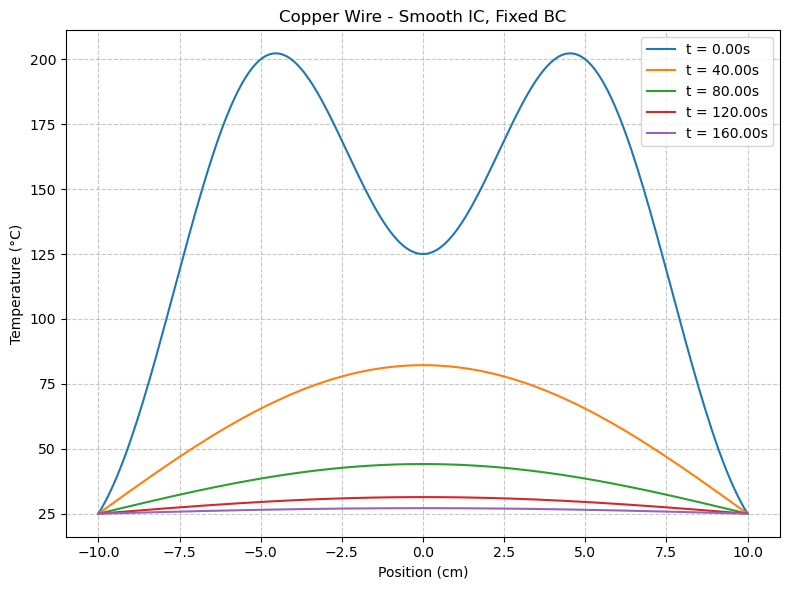

In [9]:
# Example 1: Run simulation for a single metal
copper_sim = MetalConduction(metal_name='Copper', ic_type='smooth', bc_type='fixed')
copper_sim.initialize_simulation(simulation_time=160)
copper_sim.run_simulation()

# Plot the temperature profile
plt.figure(figsize=(10, 6))
copper_sim.plot_temperature_profile()
plt.tight_layout()
plt.show()


### Smooth-Fixed Simulations:

**(d)** Pick **two metal wires** from the dictionary and run both simulations using your Crank-Nicolson algorithm. To compare the results, make a high-quality, 2-column figure showing the time evolution of the 1D temperature profile, $T=T(x, t)$, of each metal wire versus $x$ at a few selected times.


Initialized Copper wire simulation
Diffusivity: 1.11 cm²/s
r factor: 1.1100
Simulation initialized for 160 seconds with 16001 time steps
Thermal equilibrium reached at t = 140.52 seconds
Simulation completed in 3.51 seconds
Initialized Steel wire simulation
Diffusivity: 0.18 cm²/s
r factor: 0.1800
Simulation initialized for 500 seconds with 50001 time steps
Thermal equilibrium reached at t = 456.70 seconds
Simulation completed in 10.92 seconds


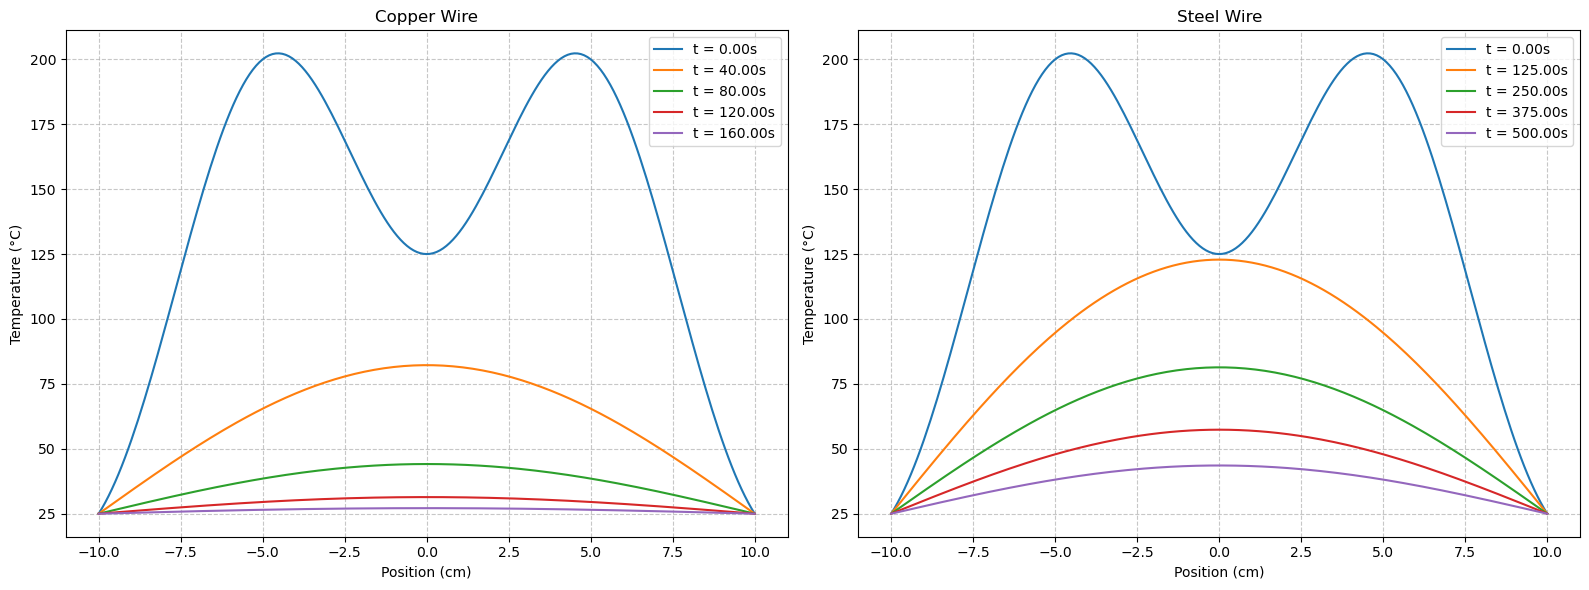

In [10]:
# Compare two metals 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Simulate Copper
copper_sim = MetalConduction(metal_name='Copper', ic_type='smooth', bc_type='fixed')
copper_sim.initialize_simulation(simulation_time=160)
copper_sim.run_simulation()
copper_sim.plot_temperature_profile(ax=ax1, title='Copper Wire')

# Simulate Steel
steel_sim = MetalConduction(metal_name='Steel', ic_type='smooth', bc_type='fixed')
steel_sim.initialize_simulation(simulation_time=500)
steel_sim.run_simulation()
steel_sim.plot_temperature_profile(ax=ax2, title='Steel Wire')

plt.tight_layout()
plt.show()



### Smooth-Fixed versus Noisy-Fixed Simulations:

**(e)** Study heat diffusion only in the Zinc wire considering **smooth versus noisy initial conditions** with noise of 3 different amplitudes. To compare the results, make a high-quality, 4-panel figure (with 2 columns and 2 rows) showing the time evolution of the 1D temperature profile, $T=T(x, t)$, of the Zinc metal wire versus $x$ at a few selected times, under different initial conditions (smooth vs. 3 noisy cases).


Initialized Zinc wire simulation
Diffusivity: 0.63 cm²/s
r factor: 0.6300
Simulation initialized for 250 seconds with 25001 time steps
Thermal equilibrium reached at t = 211.11 seconds
Simulation completed in 5.47 seconds
Initialized Zinc wire simulation
Diffusivity: 0.63 cm²/s
r factor: 0.6300
Simulation initialized for 250 seconds with 25001 time steps
Thermal equilibrium reached at t = 211.13 seconds
Simulation completed in 5.51 seconds
Initialized Zinc wire simulation
Diffusivity: 0.63 cm²/s
r factor: 0.6300
Simulation initialized for 250 seconds with 25001 time steps
Thermal equilibrium reached at t = 211.15 seconds
Simulation completed in 5.50 seconds
Initialized Zinc wire simulation
Diffusivity: 0.63 cm²/s
r factor: 0.6300
Simulation initialized for 250 seconds with 25001 time steps
Thermal equilibrium reached at t = 210.74 seconds
Simulation completed in 5.56 seconds


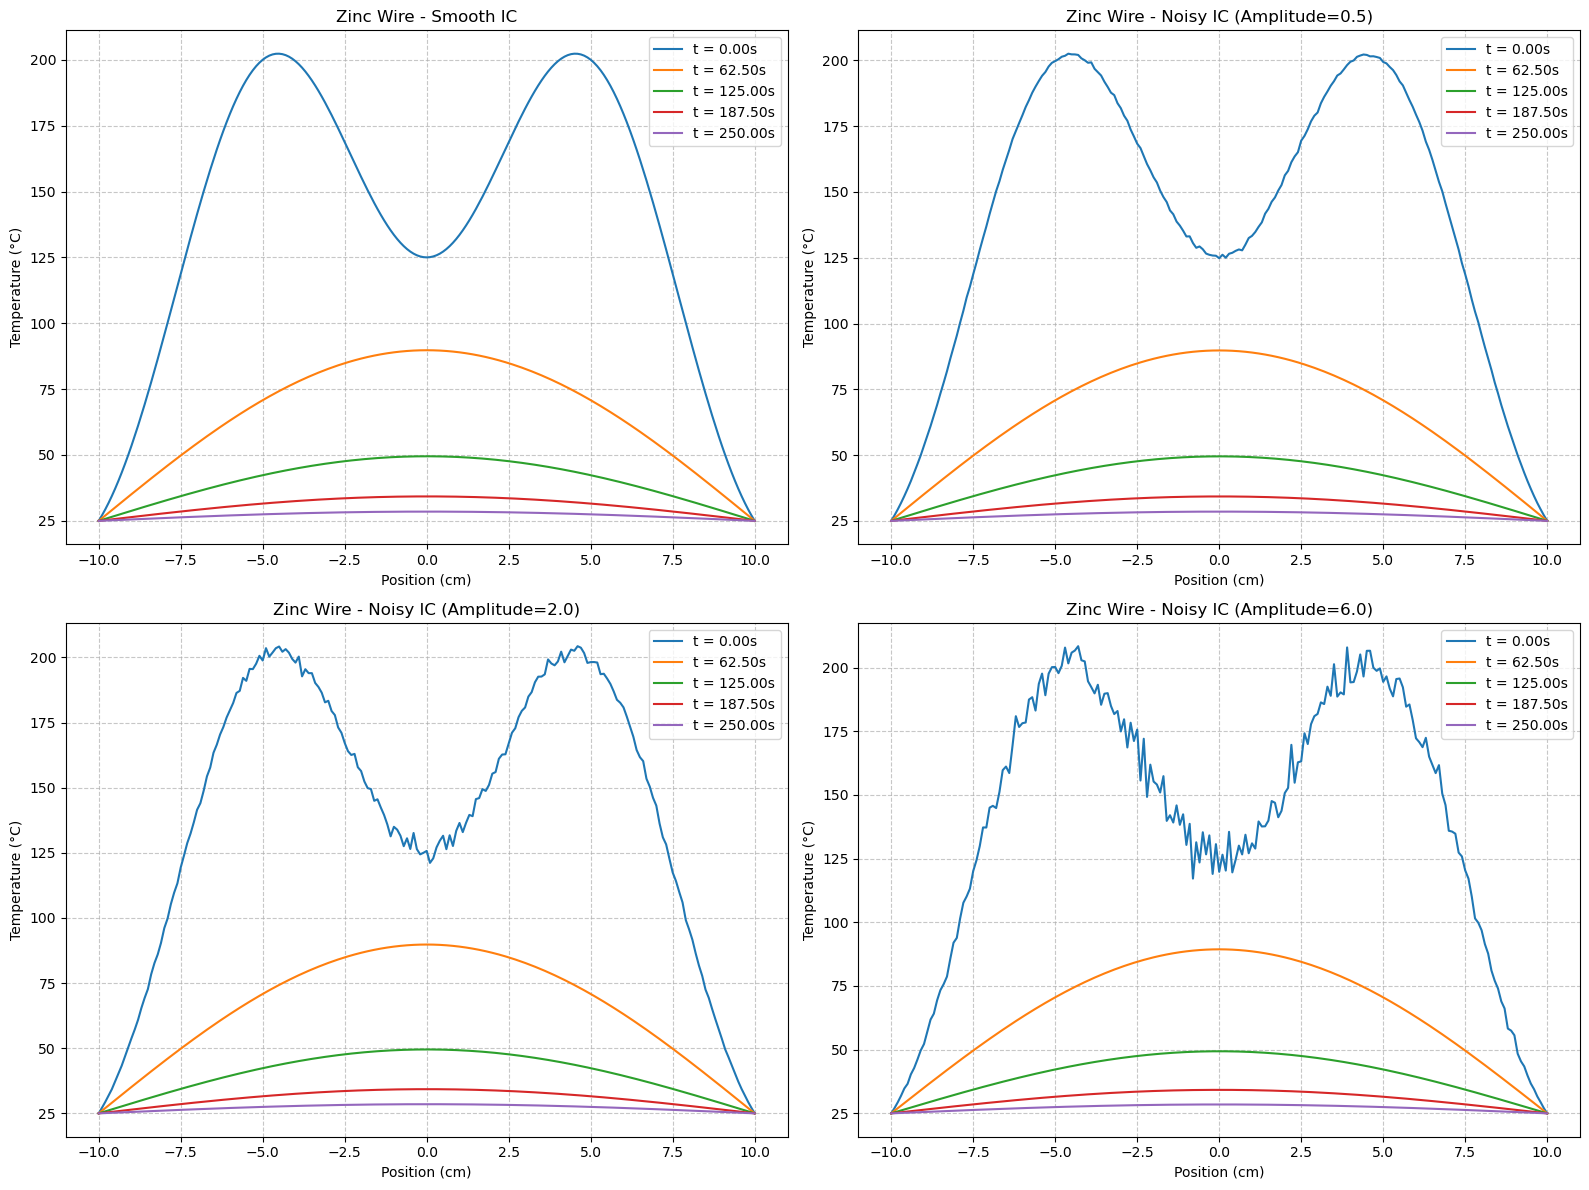

In [11]:
# Compare smooth vs noisy initial conditions 
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Smooth initial condition
zinc_smooth = MetalConduction(metal_name='Zinc', ic_type='smooth', bc_type='fixed')
zinc_smooth.initialize_simulation(simulation_time=250)
zinc_smooth.run_simulation()
zinc_smooth.plot_temperature_profile(ax=axes[0, 0], title='Zinc Wire - Smooth IC')

# Noisy initial conditions with different amplitudes
amplitudes = [0.5, 2.0, 6.0]
for i, amp in enumerate(amplitudes):
    row, col = divmod(i + 1, 2)
    zinc_noisy = MetalConduction(metal_name='Zinc', ic_type='noisy', noise_amplitude=amp, bc_type='fixed')
    zinc_noisy.initialize_simulation(simulation_time=250)
    zinc_noisy.run_simulation()
    zinc_noisy.plot_temperature_profile(
        ax=axes[row, col], 
        title=f'Zinc Wire - Noisy IC (Amplitude={amp})'
    )

plt.tight_layout()
plt.show()



### Smooth-Fixed versus Smooth-Varying Simulations:

**(f)** Study heat diffusion only in the Aluminum wire considering **fixed versus varying boundary conditions**. To compare the results, make a high-quality, 2-column figure showing the time evolution of the 1D temperature profile, $T=T(x, t)$, of the Aluminum metal wire versus $x$ at a few selected times, under different boundary conditions.


Initialized Aluminum wire simulation
Diffusivity: 0.97 cm²/s
r factor: 0.9700
Simulation initialized for 170 seconds with 17001 time steps
Thermal equilibrium reached at t = 155.16 seconds
Simulation completed in 3.77 seconds
Initialized Aluminum wire simulation
Diffusivity: 0.97 cm²/s
r factor: 0.9700
Simulation initialized for 300 seconds with 30001 time steps
Simulation completed in 6.62 seconds


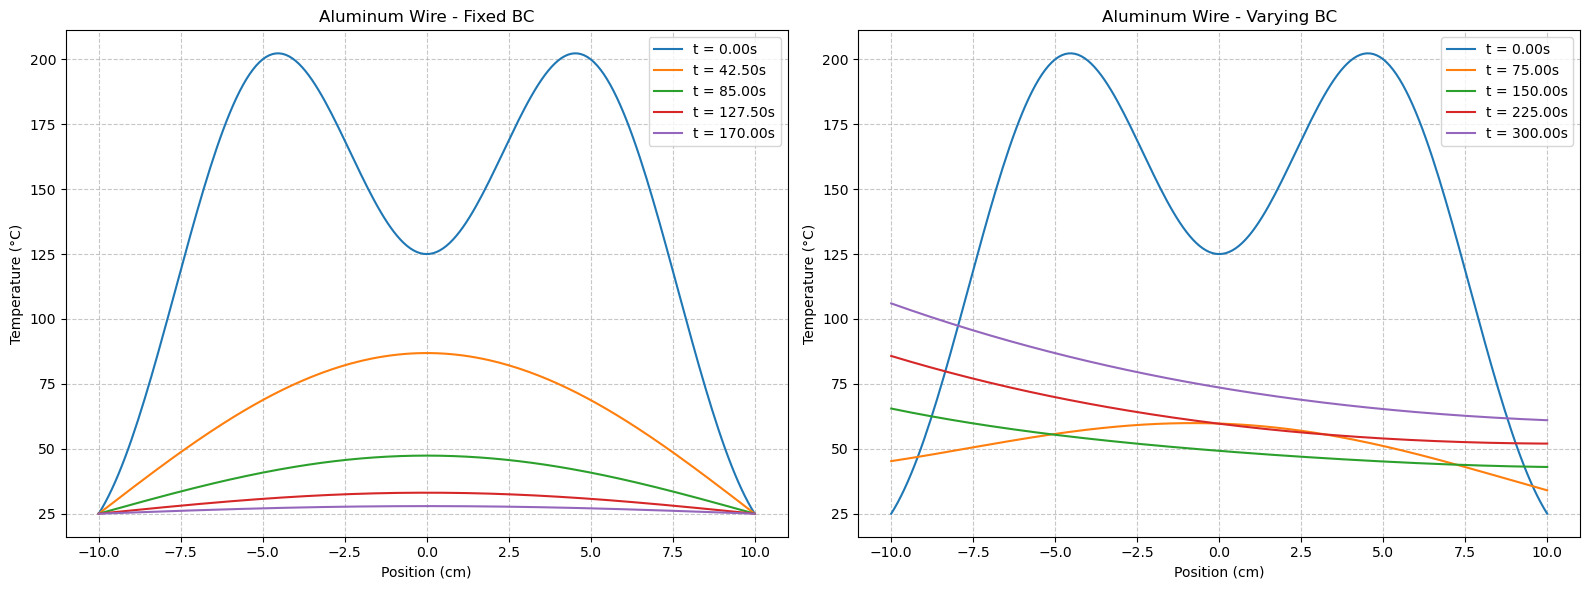

In [12]:
# Fixed vs varying boundary conditions 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Fixed boundary conditions
aluminum_fixed = MetalConduction(metal_name='Aluminum', ic_type='smooth', bc_type='fixed')
aluminum_fixed.initialize_simulation(simulation_time=170)
aluminum_fixed.run_simulation()
aluminum_fixed.plot_temperature_profile(ax=ax1, title='Aluminum Wire - Fixed BC')

# Varying boundary conditions
aluminum_varying = MetalConduction(metal_name='Aluminum', ic_type='smooth', bc_type='varying')
aluminum_varying.initialize_simulation(simulation_time=300)
aluminum_varying.run_simulation()
aluminum_varying.plot_temperature_profile(ax=ax2, title='Aluminum Wire - Varying BC')

plt.tight_layout()
plt.show()


### Analysis:

**(g)** Can we use explicit or FFT methods to solve this problem? Explain. 

    - Yes, we could use explicit methods (like Forward Euler) to solve this heat conduction problem, but they would require smaller time steps to maintain stability (dt ≤ dx²/2α, where α is thermal diffusivity). The code currently implements the Crank-Nicolson method, which is implicit and unconditionally stable. FFT methods would also be suitable for this problem since the heat equation is linear and has constant coefficients. Only if we ensure that periodic boundary conditions do not create inestability or divergence on the solutions

**(h)** Does the input noise amplitude change the time at which thermal equilibrium is reached or not? Why?

    - Yes, the input noise amplitude affects the time to reach thermal equilibrium. In the code, equilibrium is reached when the maximum temperature change between time steps falls below the threshold (0.001°C) for 5 consecutive steps. Higher noise amplitudes create more local temperature gradients requiring additional time to smooth out. The apodisation function ensures noise gradually diminishes near boundaries, preventing artificial boundary effects while maintaining noise impact in the central region of the wire.

**(i)** What is the effect of a faulty cooling system on the temperature profile?

    - A faulty cooling system would be represented by inconsistent or elevated boundary conditions. In this simulation, changing from 'fixed' to 'varying' boundary conditions models \such a scenario. This failure prevents the system from reaching equilibrium as continuous heat is added. The temperature profile would show persistent asymmetry and generally higher temperatures throughout the wire, with a steeper gradient toward the end with the higher temperature rise rate 

## 2. Joblib Parallelisation (8 points)

Consider the same statement provided in problem 1. All code should be organised in **python classes**.

### Parallelisation with joblib:

**(a)** Imagine we wish to run several simulations in parallel for the metals included in the dictionary. Within the **metalconduction.ipynb** notebook, create a routine that uses ```joblib``` to parallelise the simulation executions in $n$ CPUs.

**(b)** Test your implementation by running $2$ simulations ($1$ for Iron and $1$ for Lead) first in serial and then in parallel (simultaneously). For the serial run, $n=1$ CPU core. For the parallel run, $n=2$ CPU cores. The time should go down. **Hint:** You need to add time stamps to quantify and return log files with the execution times. 

**(c)** Make a scaling plot showing (serial and parallel) execution times in the $Y$ axis versus the number of CPU cores ($n$) in the $X$ axis.


In [13]:
# Run parallel simulations (Task b)
metals = ['Iron', 'Lead']


# Serial run
print("Running serial simulation (n_jobs=1)...")
serial_results, serial_time = run_parallel_simulations(
    metals, 
    n_jobs=1,
    dx=0.1,
    dt=0.01,
    ic_type='smooth',
    bc_type='fixed',
    sim_time=500  
)
print(f"Serial time: {serial_time:.2f} seconds")

# Parallel run
print("Running parallel simulation (n_jobs=2)...")
parallel_results, parallel_time = run_parallel_simulations(
    metals, 
    n_jobs=2,
    dx=0.1,
    dt=0.01,
    ic_type='smooth',
    bc_type='fixed',
    sim_time=500  
)
print(f"Parallel time: {parallel_time:.2f} seconds")
print(f"Speedup: {serial_time/parallel_time:.2f}x")

Running serial simulation (n_jobs=1)...
Initialized Iron wire simulation
Diffusivity: 0.23 cm²/s
r factor: 0.2300
Simulation initialized for 500 seconds with 50001 time steps
Thermal equilibrium reached at t = 400.62 seconds
Simulation completed in 11.50 seconds
Data saved to outputfolder/Iron_smooth_fixed.log
Initialized Lead wire simulation
Diffusivity: 0.22 cm²/s
r factor: 0.2200
Simulation initialized for 500 seconds with 50001 time steps
Thermal equilibrium reached at t = 410.64 seconds
Simulation completed in 11.06 seconds
Data saved to outputfolder/Lead_smooth_fixed.log
All simulations completed in 34.30 seconds using 1 cores
Serial time: 34.30 seconds
Running parallel simulation (n_jobs=2)...
Initialized Lead wire simulation
Diffusivity: 0.22 cm²/s
r factor: 0.2200
Initialized Iron wire simulation
Diffusivity: 0.23 cm²/s
r factor: 0.2300
Simulation initialized for 500 seconds with 50001 time steps
Simulation initialized for 500 seconds with 50001 time steps
Thermal equilibrium 

Running scaling tests...
Testing with 1 cores...
Initialized Iron wire simulation
Diffusivity: 0.23 cm²/s
r factor: 2.3000
Simulation initialized for 500 seconds with 5001 time steps
Simulation completed in 1.52 seconds
Data saved to outputfolder/Iron_smooth_fixed.log
Initialized Lead wire simulation
Diffusivity: 0.22 cm²/s
r factor: 2.2000
Simulation initialized for 500 seconds with 5001 time steps
Simulation completed in 1.46 seconds
Data saved to outputfolder/Lead_smooth_fixed.log
  Time: 4.86 seconds
Testing with 2 cores...
Initialized Iron wire simulation
Diffusivity: 0.23 cm²/s
r factor: 2.3000
Simulation initialized for 500 seconds with 5001 time steps
Initialized Lead wire simulation
Diffusivity: 0.22 cm²/s
r factor: 2.2000
Simulation initialized for 500 seconds with 5001 time steps
Simulation completed in 1.15 seconds
Data saved to outputfolder/Iron_smooth_fixed.log
Simulation completed in 1.14 seconds
Data saved to outputfolder/Lead_smooth_fixed.log
  Time: 2.98 seconds
Testi

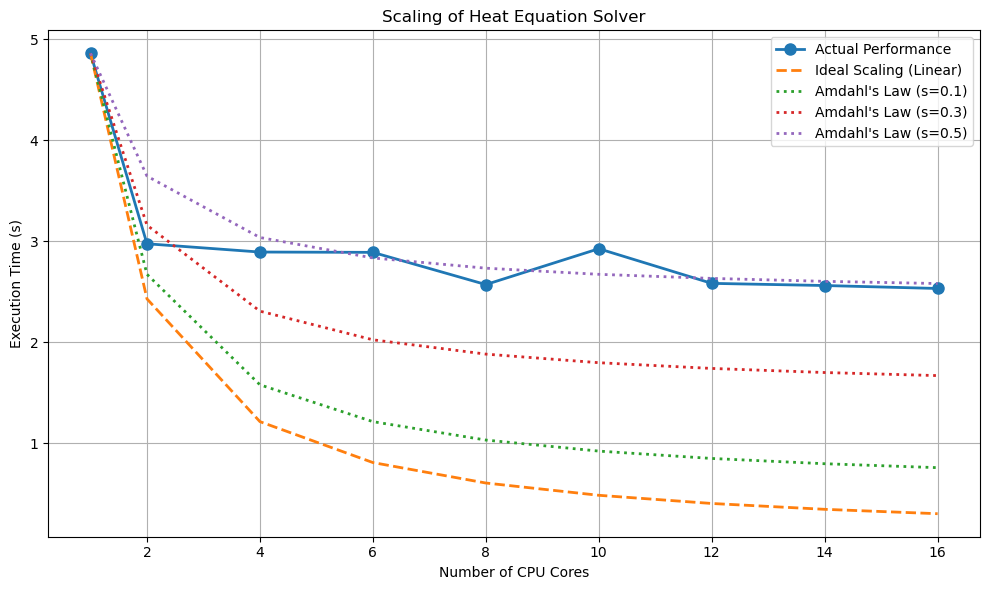

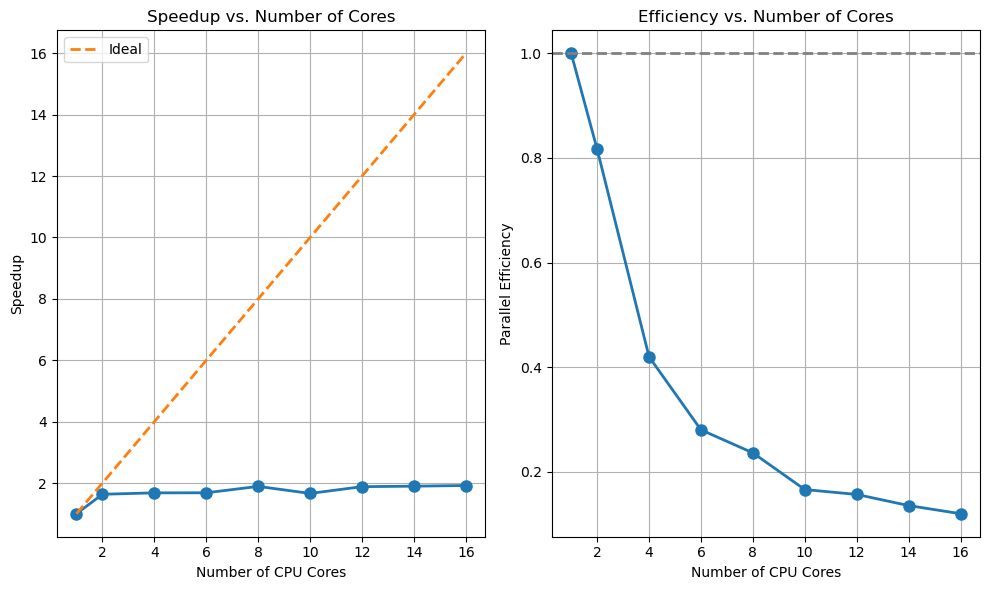

In [18]:
import time

# Make scaling plot (Task c)

# Use a longer simulation time to ensure we can measure performance properly
# Also use both metals with specific simulation times based on their diffusivity
metals = ['Iron', 'Lead']
sim_params = {'Iron': {'sim_time': 500}, 'Lead': {'sim_time': 500}}

# Define range of core counts to test
core_counts = [1, 2, 4, 6, 8, 10, 12, 14, 16]  

# Function to run tests and measure time
def run_scaling_test(n_cores):
    start_time = time.time()
    
    # Run each metal with its appropriate simulation time
    results = Parallel(n_jobs=n_cores)(
        delayed(run_metal_simulation)(
            metal, 
            dx=0.1,
            dt=0.1,
            ic_type='smooth',
            bc_type='fixed',
            sim_time=sim_params[metal]['sim_time']
        ) for metal in metals
    )
    
    end_time = time.time()
    return end_time - start_time

# Run tests for each core count
times = []
print("Running scaling tests...")
for n_cores in core_counts:
    print(f"Testing with {n_cores} cores...")
    run_time = run_scaling_test(n_cores)
    times.append(run_time)
    print(f"  Time: {run_time:.2f} seconds")

# Plot results with Amdahl's law
plt.figure(figsize=(10, 6))

# Actual performance
plt.plot(core_counts, times, 'o-', linewidth=2, markersize=8, label='Actual Performance')

# Ideal scaling (linear speedup)
ideal_times = [times[0]/n for n in core_counts]
plt.plot(core_counts, ideal_times, '--', linewidth=2, label='Ideal Scaling (Linear)')

# Amdahl's law for different serial fractions
for serial_fraction in [0.1, 0.3, 0.5]:
    amdahl_times = [times[0] * (serial_fraction + (1-serial_fraction)/n) for n in core_counts]
    plt.plot(core_counts, amdahl_times, ':', linewidth=2, 
             label=f"Amdahl's Law (s={serial_fraction})")

plt.xlabel('Number of CPU Cores')
plt.ylabel('Execution Time (s)')
plt.title('Scaling of Heat Equation Solver')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate and display speedup
speedups = [times[0]/t for t in times]
efficiency = [s/n for s, n in zip(speedups, core_counts)]

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(core_counts, speedups, 'o-', linewidth=2, markersize=8)
plt.plot(core_counts, core_counts, '--', linewidth=2, label='Ideal')
plt.xlabel('Number of CPU Cores')
plt.ylabel('Speedup')
plt.title('Speedup vs. Number of Cores')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(core_counts, efficiency, 'o-', linewidth=2, markersize=8)
plt.axhline(y=1.0, linestyle='--', color='gray', linewidth=2)
plt.xlabel('Number of CPU Cores')
plt.ylabel('Parallel Efficiency')
plt.title('Efficiency vs. Number of Cores')
plt.grid(True)

plt.tight_layout()
plt.show()


### HPC execution:

**(d)** Convert your notebook code into a script called: **metalconduction.py**. Then, copy it to the CEDIA cluster (or the Imbabura cluster), reserve computing resources (e.g. $8$ CPU cores), then run your code in serial and parallel for all the $8$ metals at increasing $n$ (e.g. $1$, $2$, $4$, $8$ CPU cores). Export log files from each run, so that the thermal equilibrium times and simulation run times can be analysed later. Include the log files and all your SLURM job scripts in the **outputfolder.**

**(e)** Within the **metalconduction.ipynb** notebook, create a routine to open the log files produced by the serial run and all the different parallel runs on the HPC cluster.

**(f)** Make a new scaling plot for the HPC cluster showing the executions times on the Y-axis and number of cores on the X-axis. Display also the **Amdahl's law**. 


In [15]:
def display_log_file(filepath):
    """
    Read and display the contents of a .log file.
    
    Parameters:
    -----------
    filepath : str
        Path to the .log file to display.
    """
    try:
        with open(filepath, 'r') as f:
            content = f.read()
        print(content)
    except FileNotFoundError:
        print(f"File not found: {filepath}")
    except Exception as e:
        print(f"Error reading file {filepath}: {e}")

# Example usage:
display_log_file('./outputfolder/hpc_results/output_results/performance_summary.txt') #Change the route to see any other .log file

Metal Conduction Simulation - Performance Summary

Execution Times with Different Core Counts:
------------------------------------------
1 cores: 212.3852 seconds
2 cores: 73.9627 seconds
4 cores: 52.0104 seconds
6 cores: 28.9551 seconds
8 cores: 21.6404 seconds
10 cores: 17.3457 seconds
12 cores: 14.0880 seconds
14 cores: 14.2723 seconds
16 cores: 14.0575 seconds

Speedup Relative to Single Core:
-------------------------------
1 cores: 1.00x speedup (100.0% efficiency)
2 cores: 2.87x speedup (143.6% efficiency)
4 cores: 4.08x speedup (102.1% efficiency)
6 cores: 7.33x speedup (122.2% efficiency)
8 cores: 9.81x speedup (122.7% efficiency)
10 cores: 12.24x speedup (122.4% efficiency)
12 cores: 15.08x speedup (125.6% efficiency)
14 cores: 14.88x speedup (106.3% efficiency)
16 cores: 15.11x speedup (94.4% efficiency)

------------------------------------------
Generated on: 2025-05-20 21:33:35



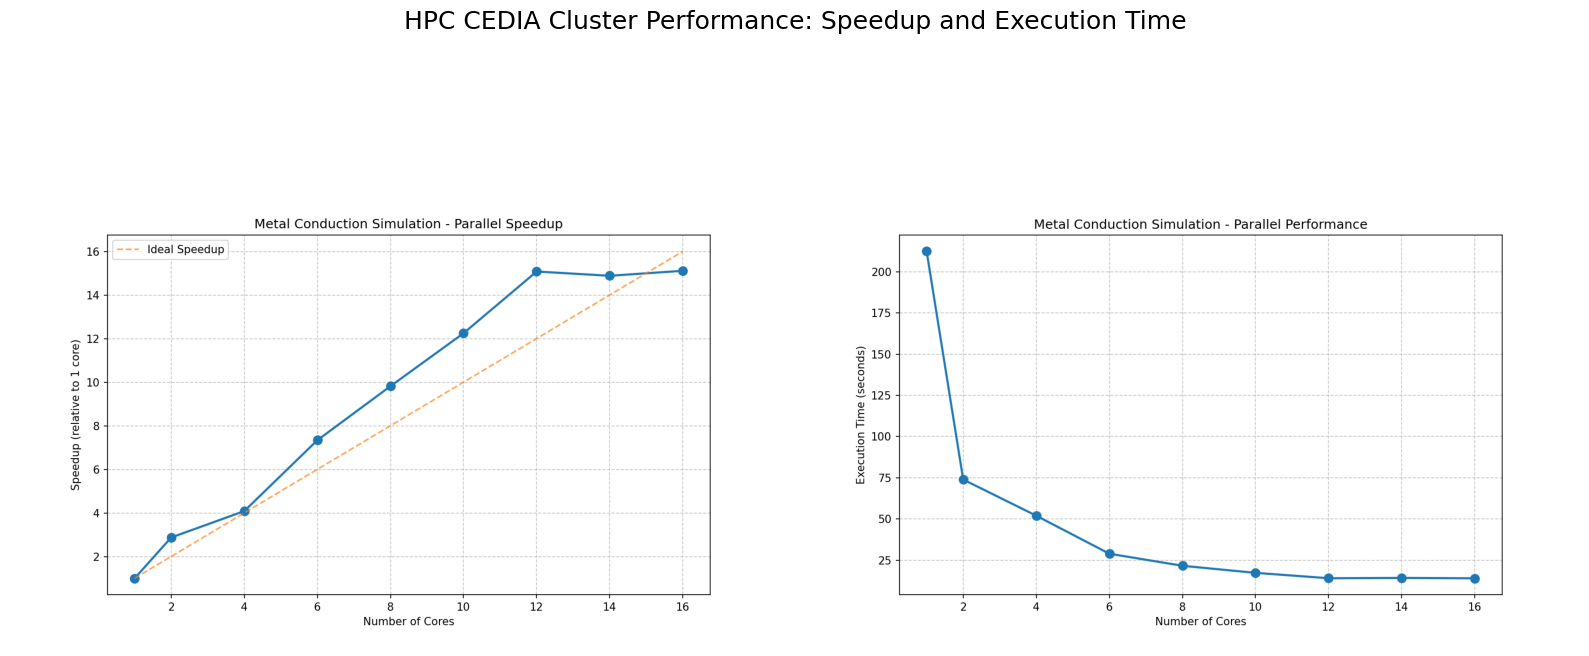

In [16]:
image = plt.imread('./outputfolder/hpc_results/output_results/performance_speedup.png')
image2 =plt.imread('./outputfolder/hpc_results/output_results/performance_time.png')
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(image)
ax[0].axis('off')
ax[1].imshow(image2)
ax[1].axis('off')
fig.suptitle("HPC CEDIA Cluster Performance: Speedup and Execution Time", fontsize=18)
plt.tight_layout()  
plt.show()


### Analysis:

**(g)** Compare the Amdahl's law to your results and comment on the findings (e.g. does your parallelisation follow Amdahl's law? Why yes or no?)

    - Looking at the Metal Conduction Simulation results, the parallelization partially follows Amdahl's Law but with notable deviations. The speedup plateaus at around 15x with 16 cores, suggesting roughly 93-95% of the code is parallelizable, which aligns with Amdahl's theoretical limits. However, the super-linear speedup observed between 4-12 cores (exceeding the ideal line) contradicts Amdahl's Law and likely results from cache effects as the workload divides among more cores, each portion fits better in cache memory, reducing access times. This memory hierarchy benefit isn't accounted for in the classic Amdahl model. Beyond 12 cores, diminishing returns become evident as communication overhead and load imbalance begin to outweigh the benefits of additional parallelization, demonstrating the practical limitations that Amdahl's Law fundamentally predicts.

**(h)** Make a plot showing the thermal equilibrium times versus diffusivities. Do the different thermal equilibrium times for dstinct metals influence how ```joblib``` handles parallelisation?

    - In joblib parallelisation, each simulation runs independently, so differences in equilibrium times mainly affect load balancing. If some metals take much longer to reach equilibrium, CPU cores assigned to faster metals may finish early and remain idle, reducing parallel efficiency. For best performance, tasks should have similar runtimes, or dynamic scheduling should be used.


In [17]:
# # Extract diffusivities and equilibrium times from results
# diff_values = [res['diffusivity'] for res in results]
# eq_times = [float(res['equilibrium_time']) for res in results]


# # Plot equilibrium times vs diffusivities
# plt.figure(figsize=(8, 6))
# plt.scatter(diff_values, eq_times, color='royalblue', s=80)
# plt.xlabel('Thermal Diffusivity (cm²/s)')
# plt.ylabel('Thermal Equilibrium Time (s)')
# plt.title('Thermal Equilibrium Time vs Diffusivity')
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

